In [1]:
# -- driver_run_forecast_LV2_v1.py  --
# master python script to do a full LV2 forecast simulation

import sys
#import pickle
#import numpy as np
import os
from datetime import datetime
#import gc
#import resource
import subprocess
#import netCDF4 as nc
#import matplotlib.pyplot as plt
#from scipy.interpolate import RegularGridInterpolator, LinearNDInterpolator,interp1d

##############

sys.path.append('../sdpm_py_util')
from init_funs import remake_PFM_pkl_file
#import atm_functions as atmfuns
#import ocn_functions as ocnfuns
#import grid_functions as grdfuns
#import plotting_functions as pltfuns
from get_PFM_info import get_PFM_info
#from init_funs import initialize_simulation
from make_LV1_dotin_and_SLURM import make_LV1_dotin_and_SLURM
from make_LV2_dotin_and_SLURM import make_LV2_dotin_and_SLURM
from run_slurm_LV1 import run_slurm_LV1
from run_slurm_LV2 import run_slurm_LV2


level = 3

In [2]:
# need to run the LV1 simulation to make LV1_his.nc
# and get the raw hycom and atm data.  
cmd_list = ['python','-W','ignore','driver_run_forecast_LV1_v4.py'] # this is in the .../PFM/driver/ directory
ret1 = subprocess.run(cmd_list)     



Starting the LV1 simulation, Current time  2024-09-03 13:45:20.536939
we are going to start clean...
getting PFM info...
PFM info was loaded from /scratch/PFM_Simulations/PFM_run_info.pkl
removing PFM info file...
now removing all input files...
PFM info was saved as /scratch/PFM_Simulations/PFM_run_info.pkl
Starting: driver_run_forecast_LV1
Current local Time = 2024-09-03 13:45:20.591638 UTC =  2024-09-03 20:45:20.591642+00:00  Fetch time =  2024-09-02 12:00:00

Preparing forecast starting on 20240902 at  1200
ocean boundary and initial conditions will be from:
hycom
atm forcing will be from:
nam_nest

Getting OCN forecast data. Going to use subprocess, and save a pickle file of ocn data.
PFM info was loaded from /scratch/PFM_Simulations/PFM_run_info.pkl
in the parallel ncks switch
Time to get full file using parallel ncks = 219.58 sec
Return code = 0 (0=success, 1=skipped ncks)

max and min raw hycom data (iz is top [0] to bottom [39]):
max zeta   =  0.375 m          at  ( it, ilat,

In [2]:
t00=datetime.now()
sd = '20240903'
remake_PFM_pkl_file(sd) # this function will remake the PFM.pkl file. Good for developing when get_PFM_info.py changes, but you don't want to re run from the start.
PFM=get_PFM_info()


we are remaking the PFM.pkl file...
getting PFM info...
removing PFM info file...
PFM info was saved as /scratch/PFM_Simulations/PFM_run_info.pkl
now changing the start date to:  20240903
fetch_time is now:  2024-09-03
resaving the PFM.pkl file with specified start time.
PFM info was resaved as /scratch/PFM_Simulations/PFM_run_info.pkl


In [4]:
# putting atm raw data on to the roms LV2 grid
t1 = datetime.now()
# put the atm data on the roms grid, and rotate the velocities
# everything in this dict turn into the atm.nc file
print('in atmfuns.get_atm_data_on_roms_grid(ATM,RMG)')
print('doing level: ' + str(level))
cmd_list = ['python','-W','ignore','atm_functions.py','get_atm_data_on_roms_grid',str(level)]
os.chdir('../sdpm_py_util')
ret5 = subprocess.run(cmd_list)   
print('return code: ' + str(ret5.returncode) + ' (0=good)')  
os.chdir('../sdpm_py_util')
print('done with: atmfuns.get_atm_data_on_roms_grid(ATM,RMG)')
# all the fields plotted with the data on roms grid
t2 = datetime.now()
print('this took:')
print(t2-t1)
print('\n')



in atmfuns.get_atm_data_on_roms_grid(ATM,RMG)
doing level: 3

ATM on roms grid dict saved with pickle.
return code: 0 (0=good)
done with: atmfuns.get_atm_data_on_roms_grid(ATM,RMG)
this took:
0:00:01.737165




In [5]:
# plot both raw and LV2 atm fields
t1 = datetime.now()
plot_all_atm = 1
if plot_all_atm == 1:
    cmd_list = ['python','-W','ignore','plotting_functions.py','plot_all_fields_in_one',str(level)]
    print('plotting atm and atm on roms grid...')
    os.chdir('../sdpm_py_util')
    ret5 = subprocess.run(cmd_list)   
    print('return code: ' + str(ret5.returncode) + ' (0=good)')  
    print('driver_run_forecast_L21:  done with writing LV2_ATM.nc file.') #pltfuns.plot_all_fields_in_one(str(level))
    print('...done with: pltfuns.plot_all_fields_in_one')

t2 = datetime.now()
print('this took:')
print(t2-t1)
print('\n')


plotting atm and atm on roms grid...
return code: 0 (0=good)
driver_run_forecast_L21:  done with writing LV2_ATM.nc file.
...done with: pltfuns.plot_all_fields_in_one
this took:
0:00:10.513550




In [6]:
# save the atm data into LV2_atm.nc
t1 = datetime.now()
print('driver_run_forcast_LV2: saving LV2_ATM.nc file')
#atmfuns.atm_roms_dict_to_netcdf(str(level))
os.chdir('../sdpm_py_util')
cmd_list = ['python','-W','ignore','atm_functions.py','atm_roms_dict_to_netcdf',str(level)]
ret5 = subprocess.run(cmd_list)   
print('return code: ' + str(ret5.returncode) + ' (0=good)')  
os.chdir('../sdpm_py_util')
print('driver_run_forecast_L21:  done with writing LV2_ATM.nc file.') 
# put in a function to plot the atm.nc file if we want to
print('this took:')
t2 = datetime.now()
print(t2-t1)
print('\n')


driver_run_forcast_LV2: saving LV2_ATM.nc file
file_out is:
/scratch/PFM_Simulations/LV3_Forecast/Forc/LV3_ATM_FORCING.nc
return code: 0 (0=good)
driver_run_forecast_L21:  done with writing LV2_ATM.nc file.
this took:
0:00:01.020010




In [2]:
t1 = datetime.now()
print('driver_run_forcast_LV2: saving LV'+str(level)+'_OCN_BC pickle file')
os.chdir('../sdpm_py_util')
cmd_list = ['python','-W','ignore','ocn_functions.py','mk_LV2_BC_dict',str(level)]
ret5 = subprocess.run(cmd_list)   
print('return code: ' + str(ret5.returncode) + ' (0=good)')  
os.chdir('../sdpm_py_util')
print('done with writing LV'+str(level)+'_OCN_BC.pkl file.') 
print('this took:')
t2 = datetime.now()
print(t2-t1)
print('\n')


driver_run_forcast_LV2: saving LV 3 _OCN_BC pickle file
OCN_LV2_BC dict loaded with pickle
OCN_LV 3 _BC dict saved with pickle to:  /scratch/PFM_Simulations/LV3_Forecast/Forc/BC_LV3_tmp_file.pkl
return code: 0 (0=good)
done with writing LV 3 _OCN_BC.pkl file.
this took:
0:01:16.608888




In [5]:
t1 = datetime.now()
lv3_ocnBC_pckl = PFM['lv3_forc_dir'] + '/' + PFM['lv3_ocnBC_tmp_pckl_file']
lv3_bc_file_out = PFM['lv3_forc_dir'] + '/' + PFM['lv3_bc_file']
print('driver_run_forcast_LV3: saving LV3_OCN_BC netcdf file')
os.chdir('../sdpm_py_util')
cmd_list = ['python','-W','ignore','ocn_functions.py','ocn_roms_BC_dict_to_netcdf_pckl',lv3_ocnBC_pckl,lv3_bc_file_out]
ret5 = subprocess.run(cmd_list)   
print('return code: ' + str(ret5.returncode) + ' (0=good)')  
os.chdir('../sdpm_py_util')
print('driver_run_forecast_LV3:  done with writing LV3_OCN_BC.nc file.') 
print('this took:')
t2 = datetime.now()
print(t2-t1)
print('\n')


driver_run_forcast_LV3: saving LV3_OCN_BC netcdf file
OCN_BC dict loaded with pickle

max and min of data in ROMS BC file (iz is bottom [0] to top [39]):
max zeta_north =  0.724 m          at  ( it, ilon)     =  ( 54, 241)
min zeta_north = -0.523 m          at  ( it, ilon)     =  ( 48, 146)
max zeta_south =  0.786 m          at  ( it, ilon)     =  ( 54, 185)
min zeta_south = -0.489 m          at  ( it, ilon)     =  ( 48,  98)
max zeta_west  =  0.762 m          at  ( it, ilat)     =  ( 54,   0)
min zeta_west  = -0.500 m          at  ( it, ilat)     =  ( 48, 368)
max ubar_north =  0.057 m/s        at  ( it, ilon)     =  ( 50, 234)
min ubar_north = -0.050 m/s        at  ( it, ilon)     =  (  1, 219)
max ubar_south =  0.087 m/s        at  ( it, ilon)     =  ( 23, 102)
min ubar_south = -0.151 m/s        at  ( it, ilon)     =  ( 52, 135)
max ubar_west  =  0.071 m/s        at  ( it, ilat)     =  ( 15, 320)
min ubar_west  = -0.063 m/s        at  ( it, ilat)     =  ( 44, 146)
max vbar_north =  

In [3]:
t1=datetime.now()
print('driver_run_forcast_LV3: saving LV'+str(level)+'_OCN_IC pickle file')
os.chdir('../sdpm_py_util')
cmd_list = ['python','-W','ignore','ocn_functions.py','mk_LV2_IC_dict',str(level)]
ret5 = subprocess.run(cmd_list)   
print('return code: ' + str(ret5.returncode) + ' (0=good)')  
os.chdir('../sdpm_py_util')
print('driver_run_forecast_L3:  done with writing LV3_OCN_IC.pkl file.') 
print('this took:')
t2 = datetime.now()
print(t2-t1)
print('\n')


driver_run_forcast_LV3: saving LV3_OCN_IC pickle file
LV2OCN_IC dict loaded with pickle
OCN_LV3_IC dict saved with pickle
return code: 0 (0=good)
driver_run_forecast_L3:  done with writing LV3_OCN_IC.pkl file.
this took:
0:00:05.344230




In [4]:
t1=datetime.now()
lv3_ocnIC_pckl = PFM['lv3_forc_dir'] + '/' + PFM['lv3_ocnIC_tmp_pckl_file']
lv3_ic_file_out = PFM['lv3_forc_dir'] + '/' + PFM['lv3_ini_file']
print('driver_run_forcast_LV3: saving LV3_OCN_IC netcdf file')
os.chdir('../sdpm_py_util')
cmd_list = ['python','-W','ignore','ocn_functions.py','ocn_roms_IC_dict_to_netcdf_pckl',lv3_ocnIC_pckl,lv3_ic_file_out]
ret5 = subprocess.run(cmd_list)   
print('return code: ' + str(ret5.returncode) + ' (0=good)')  
os.chdir('../sdpm_py_util')
print('driver_run_forecast_L3:  done with writing LV3_OCN_IC.nc file.') 
print('this took:')
t2 = datetime.now()
print(t2-t1)
print('\n')


driver_run_forcast_LV3: saving LV3_OCN_IC netcdf file
OCN_IC dict loaded with pickle

max and min of data in ROMS IC file (iz is bottom [0] to top [39], note: it is always 0 b/c IC):
max zeta   =  0.162 m          at  ( it, ilat, ilon)     =  (  0,  62,   0)
min zeta   =  0.107 m          at  ( it, ilat, ilon)     =  (  0, 359, 149)
max ubar   =  0.050 m/s        at  ( it, ilat, ilon)     =  (  0, 107, 189)
min ubar   = -0.029 m/s        at  ( it, ilat, ilon)     =  (  0, 161,   0)
max vbar   =  0.079 m/s        at  ( it, ilat, ilon)     =  (  0, 138, 199)
min vbar   = -0.078 m/s        at  ( it, ilat, ilon)     =  (  0, 273,  86)
max u      =  0.216 m/s        at  ( it, iz, ilat, ilon) =  (  0, 33, 197,  36)
min u      = -0.145 m/s        at  ( it, iz, ilat, ilon) =  (  0, 36,   0,   0)
max v      =  0.167 m/s        at  ( it, iz, ilat, ilon) =  (  0, 35, 273, 149)
min v      = -0.206 m/s        at  ( it, iz, ilat, ilon) =  (  0, 28, 246,  23)
max temp   = 23.537 C          at  ( it, 

In [6]:
yyyymmdd = PFM['yyyymmdd']
hhmm = PFM['hhmm']

t1=datetime.now()
os.chdir('../sdpm_py_util')
make_LV2_dotin_and_SLURM( PFM , yyyymmdd + hhmm )
print('...done')

# run command will be
print('now running roms with slurm')
run_slurm_LV2(PFM)

os.chdir('../driver')
print('this took:')
t2 = datetime.now()
print(t2-t1)
print('\n')
#print(t2-t00)


 --- making dot_in for 
...done
now running roms with slurm
run_slurm_LV2: current directory is now:  /scratch/PFM_Simulations/LV2_Forecast/Run
CompletedProcess(args=['sbatch', '--wait', 'LV2_SLURM.sb'], returncode=0, stdout=b'Submitted batch job 366\n', stderr=b'')
run_slurm_LV2: run command:  ['sbatch', '--wait', 'LV2_SLURM.sb']
subprocess slurm ran correctly? 0 (0=yes)
this took:
0:11:22.089865


Total time to do LV2 was:



Finished the LV2 simulation
now making LV2 history file plots
PFM info was loaded from /scratch/PFM_Simulations/PFM_run_info.pkl
PFM info was loaded from /scratch/PFM_Simulations/PFM_run_info.pkl
PFM info was loaded from /scratch/PFM_Simulations/PFM_run_info.pkl
PFM info was loaded from /scratch/PFM_Simulations/PFM_run_info.pkl
PFM info was loaded from /scratch/PFM_Simulations/PFM_run_info.pkl
PFM info was loaded from /scratch/PFM_Simulations/PFM_run_info.pkl
Total time to do all of LV2:


NameError: name 't00' is not defined

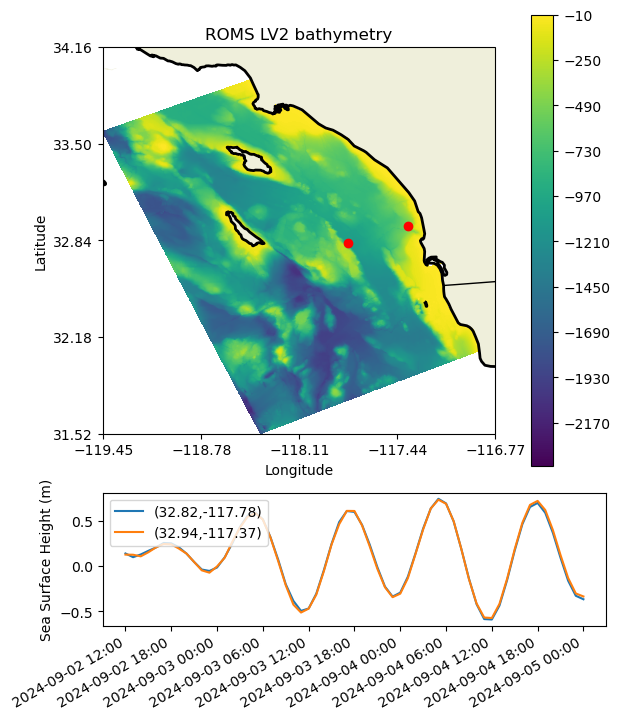

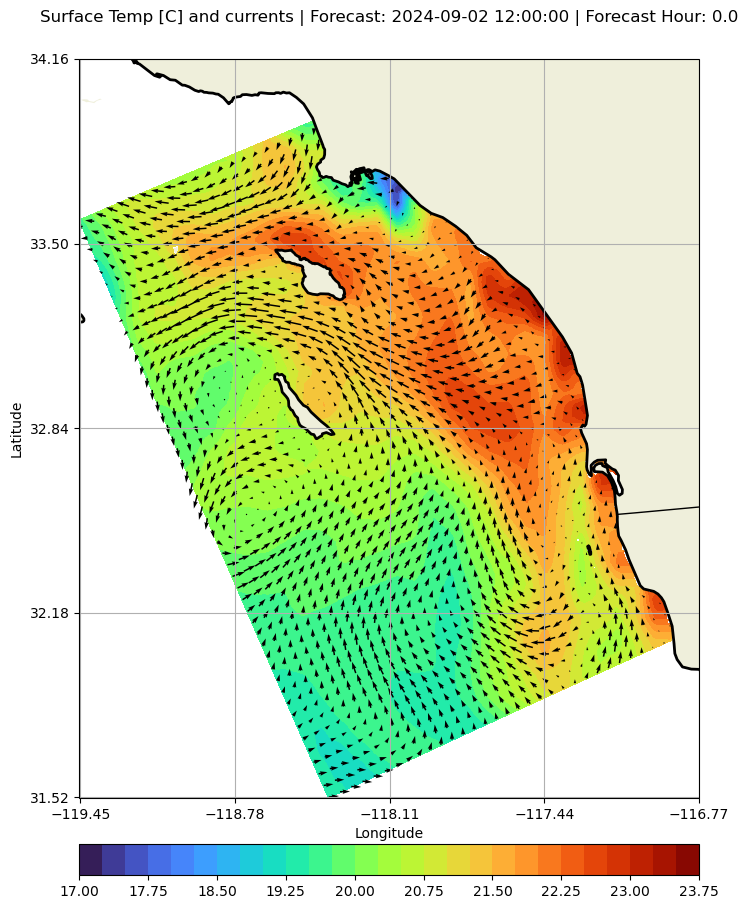

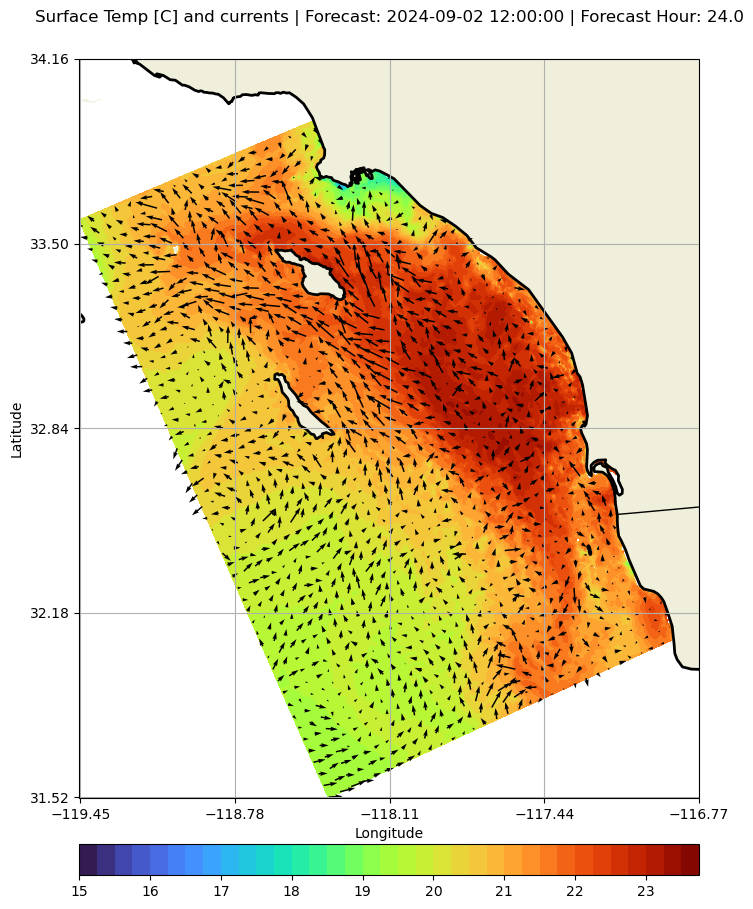

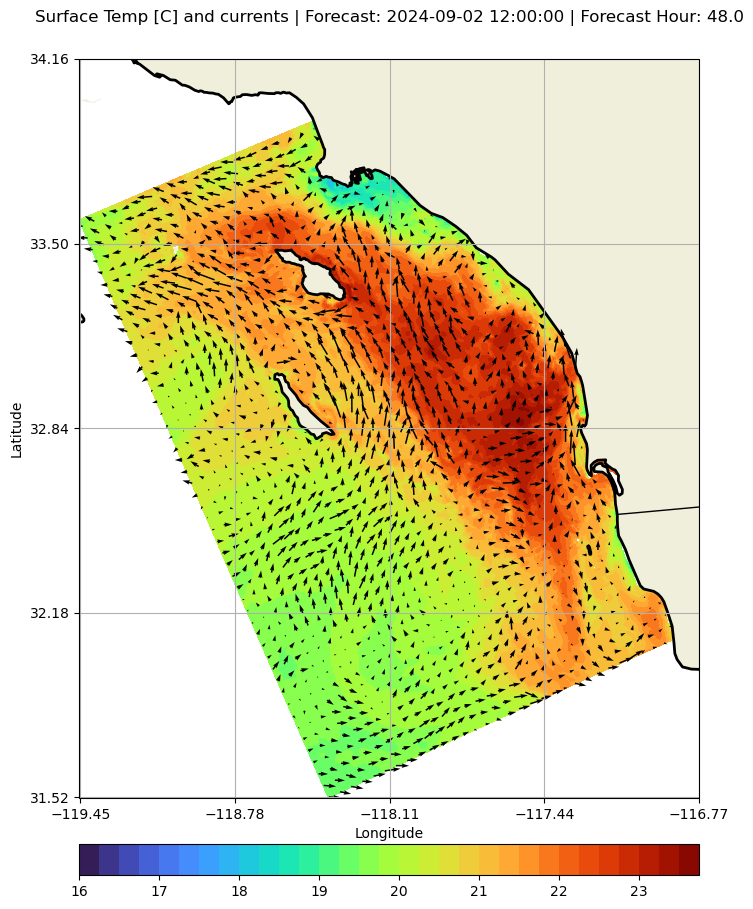

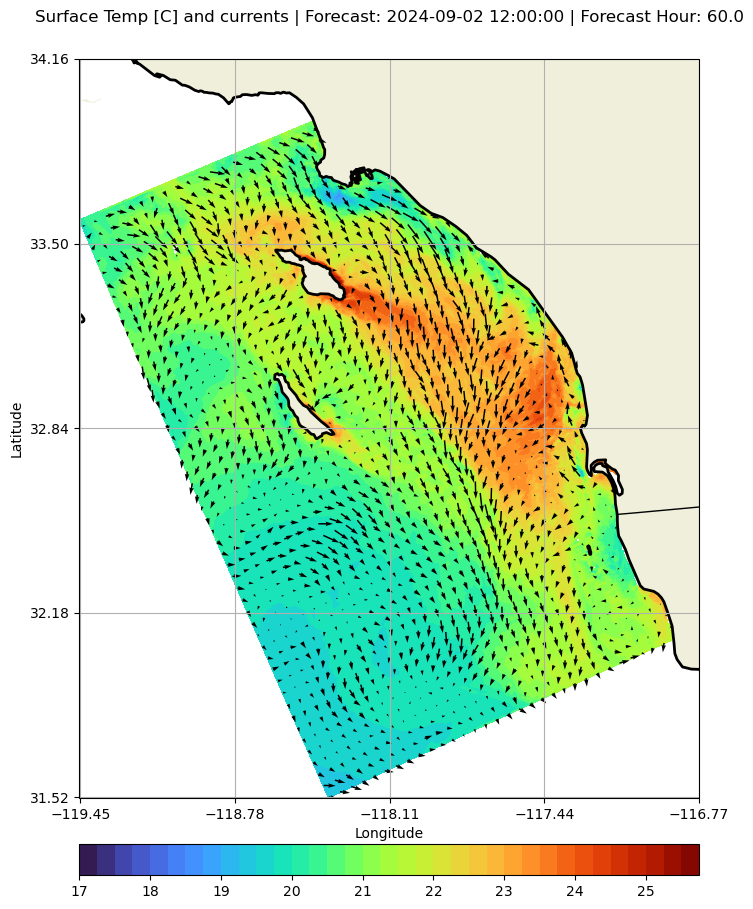

In [2]:

print('\nFinished the LV2 simulation')
print('now making LV2 history file plots')
pltfuns.make_all_his_figures('LV2')
t13 = datetime.now()
print('Total time to do all of LV2:')
print(t13-t00)


In [5]:
print(datetime.now())

2024-09-04 10:50:39.865988


In [ ]:

PFM=get_PFM_info()
G1 = grdfuns.roms_grid_to_dict(PFM['lv1_grid_file'])
G2 = grdfuns.roms_grid_to_dict(PFM['lv2_grid_file'])

fn = PFM['lv1_his_name_full']
his_ds = nc.Dataset(fn)

#vrn = 'vbar'
#zz = his_ds.variables[vrn][0,:,:]
#zz = G1['angle']

print(np.shape(G1['lat_rho']))
print(np.shape(G2['lat_rho']))


1.0
0.0
17453
81217.0


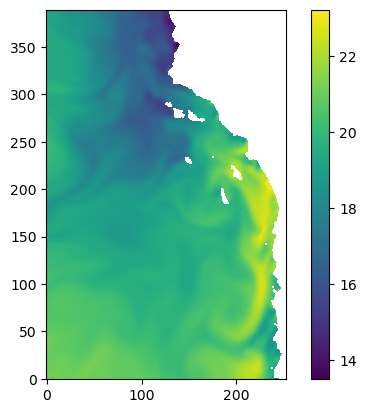

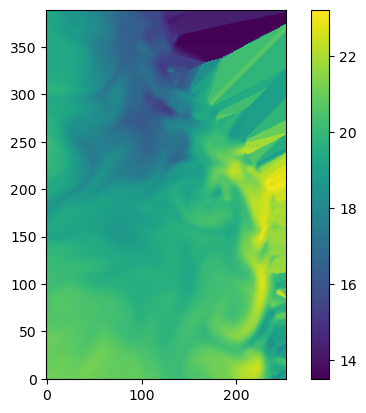

In [3]:

#print(G1['mask_rho'][-1,:])
gr_msk = G1['mask_rho']
print(gr_msk[0,0])
print(gr_msk[-1,-1])
aa = ocnfuns.get_indices_to_fill(G1['mask_rho'])

vrn = 'temp'
zz = np.squeeze(his_ds.variables[vrn][0,-1,:,:])
zz2 = zz.copy()
zz2[gr_msk==0] = zz2[gr_msk==1][aa]

print(len(aa))
print(np.sum(gr_msk))

fig, ax = plt.subplots()
pos=ax.imshow(zz ,origin='lower')
fig.colorbar(pos,ax=ax)

fig, ax = plt.subplots()
pos=ax.imshow(zz2,origin='lower')
fig.colorbar(pos,ax=ax)


In [ ]:

lt1 = his_ds.variables['lat_rho'][:]
ln1 = his_ds.variables['lon_rho'][:]
#print(np.shape(ln1))
M, L = np.shape(ln1) # M = nlat, L = nlon

lt2 = G2['lat_rho']
ln2 = G2['lon_rho']

print(np.shape(lt2))
print(np.shape(lt1))

xr1,yr1 = ocnfuns.ll2xy(ln1, lt1, np.mean(ln1), np.mean(lt1))
xr2,yr2 = ocnfuns.ll2xy(ln2, lt2, np.mean(ln1), np.mean(lt1))


if vrn == 'zeta':
    zz[zz==0] = np.nan
    
#zzf = ocnfuns.extrap_nearest_to_masked(xr1, yr1, zz, fld0=0)
zzf = zz

# set up stuff for interpolating...

X_ind, Y_ind = np.meshgrid(np.arange(L),np.arange(M))

#print(np.shape(X_ind))

parent_points = np.zeros((M*L,2))
parent_points[:,1] = xr1.flatten()
parent_points[:,0] = yr1.flatten()

xi_values = X_ind.flatten()
scat_interp_xi = LinearNDInterpolator(parent_points,xi_values)

eta_values = Y_ind.flatten()
scat_interp_eta = LinearNDInterpolator(parent_points,eta_values)

XI_child = scat_interp_xi(yr2,xr2)
ETA_child = scat_interp_eta(yr2,xr2)

xi_n = XI_child[-1,:]
xi_s = XI_child[0,:]
xi_w  = XI_child[:,0]
eta_n = ETA_child[-1,:]
eta_s = ETA_child[0,:]
eta_w  = ETA_child[:,0]

print(np.shape(lt2))
print(np.shape(XI_child))

interper = RegularGridInterpolator( (np.arange(M), np.arange(L)), np.squeeze(zzf) )
zzfi = interper((ETA_child,XI_child))

zz_n = interper((eta_n,xi_n))

print(np.shape(zzfi))

print(np.size(zz_n))

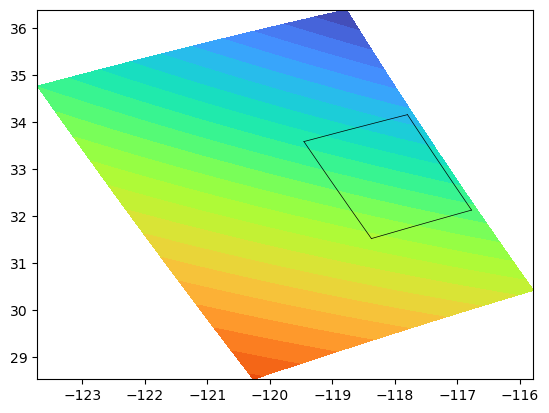

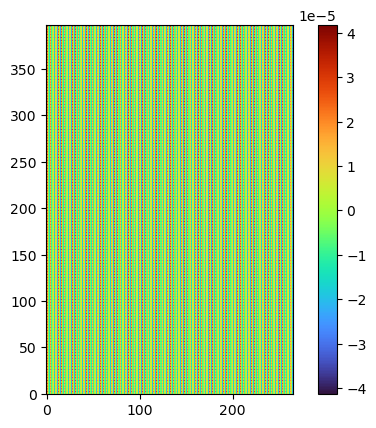

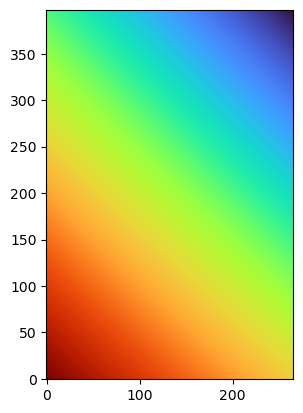

In [67]:


fig, ax = plt.subplots()
lvs = np.arange(.35,.5,.005)
ax.contourf(ln1, lt1, zzf, lvs )
ax.contourf(ln2, lt2, G2['angle'], lvs )
pltfuns.plot_roms_box(ax, G2)

fig, ax = plt.subplots()
pos=ax.imshow(G2['angle'] - zzfi ,origin='lower')
fig.colorbar(pos,ax=ax)

fig, ax = plt.subplots()
ax.imshow(zzfi,origin='lower')


In [5]:
import datetime
yyyymmdd = '20240903'
fetch_time  = datetime.date(int(yyyymmdd[0:4]),int(yyyymmdd[4:6]),int(yyyymmdd[6:8]))
print(fetch_time)


2024-09-03
